# Aula 03

## Calibração de Câmera

Em aulas anteriores vimos que uma câmera pode ser representada por duas matrizes que modelam seus parâmetros intrínsecos e extrínsecos. O problema é que para os exercícios nós assumimos que esses parâmetros são conhecidos, mas no mundo real isso dificilmente acontece.

Nesta atividade aprenderemos como obter uma estimativa desses parâmetros através de um processo de calibração.

### Observações Importantes (leia antes de continuar!)

Muitas câmeras possuem uma opção de auto foco. Você deve **desabilitar o auto foco da sua câmera antes de realizar a calibração**. Caso contrário os parâmetros vão mudar a todo instante.

## Calibração com tabuleiros ChArUco

*ChArUco* é a união dos termos *chessboard* e *ArUco* e é essencialmente o que o nome diz: um tabuleiro de xadrez com marcadores ArUco. O tabuleiro ChArUco é utilizado por ser facilmente detectado em uma imagem e os marcadores são utilizados para aprimorar a detecção dos cantos.

O OpenCV já possui funções prontas para calibrar a câmera usando um tabuleiro ChArUco.

## Intuição

Diferentemente das outras atividades, não vamos implementar a calibração "na mão", mas gostaria de apresentar uma breve intuição do processo de calibração. Como vimos anteriormente, a projeção de um ponto 3D na imagem de uma câmera pode ser representada por uma sequência de multiplicações de matrizes:

$$
\begin{pmatrix}
P'_x \\
P'_y \\
1
\end{pmatrix}
=
\begin{pmatrix}
f_x & 0 & p_x & 0 \\
0 & f_y & p_y & 0 \\
0 & 0 & 1 & 0
\end{pmatrix}
\begin{pmatrix}
E_{11} & E_{12} & E_{13} & E_{14} \\
E_{21} & E_{22} & E_{23} & E_{24} \\
E_{31} & E_{32} & E_{33} & E_{34} \\
0 & 0 & 0 & 1
\end{pmatrix}
\begin{pmatrix}
P_x \\
P_y \\
P_z \\
1
\end{pmatrix}
$$

Onde $P'$ é o ponto na imagem, em pixels, $f$ é a distância focal, $p$ é o ponto principal, $E$ é a matriz de parâmetros extrínsecos e $P$ é o ponto em 3D que será projetado na imagem. Se multiplicarmos as matrizes de parâmetros intrínsecos e extrínsecos, temos:

$$
\begin{pmatrix}
P'_x \\
P'_y \\
1
\end{pmatrix}
=
\begin{pmatrix}
C_{11} & C_{12} & C_{13} & C_{14} \\
C_{21} & C_{22} & C_{23} & C_{24} \\
C_{31} & C_{32} & C_{33} & C_{34}
\end{pmatrix}
\begin{pmatrix}
P_x \\
P_y \\
P_z \\
1
\end{pmatrix}
$$

Onde $C$ é o resultado da multiplicação das duas matrizes. Se tivermos pares de pontos $P$ e $P'$ (pontos no espaço e a sua projeção na imagem) suficientes podemos montar um sistema de equações lineares como fizemos anteriormente para o cálculo de homografias.

Entretanto, como podemos obter esses pares de pontos? Aí que entram os tabuleiros ChArUco! Em um tabuleiro ChArUco sabemos a localização de cada canto de cada marcador e de cada quadrado. Então já temos a posição $P_x$ e $P_y$ de diversos pontos, mas e a coordenada $P_z$? O tabuleiro inteiro está contido em um mesmo plano. Então podemos usar a mesma coordenada $P_z = 0$ para todos eles. Assim, os parâmetros extrínsecos serão responsáveis por mover o tabuleiro no plano $XY$ para a sua posição com relação à câmera com centro de projeção na origem.

Ufa, acabamos! Se você não entendeu direito o que discutimos até aqui, não se preocupe! Talvez a prática com código ajude. Como eu disse antes, muito do que precisamos já está implementado em funções do OpenCV.

## Obtendo os pontos de referência 

O primeiro passo é obter os pontos de referência. Para isso, salve algumas imagens com o tabuleiro em diferentes posições e distâncias. Tente obter imagens distribuindo o tabuleiro o máximo possível em posições e orientações diferentes.

<img src="arucocalibration.png" alt="Fonte: https://docs.opencv.org/3.4.3/da/d13/tutorial_aruco_calibration.html"/>

Para cada imagem, verifique que o OpenCV é capaz de detectar pelo menos 4 marcadores do tabuleiro ChArUco. Guarde as posições dos marcadores em uma lista e os IDs em outra lista.

Depois que tiver guardado as posições dos marcadores em todas as fotos, execute a função de calibração do OpenCV (`cv2.aruco.calibrateCameraCharuco`). Salve o resultado da calibração em um arquivo para não ter que calibrar todas as vezes.

## Funções úteis do OpenCV

As seguintes funções podem ser úteis para essa atividade:

- `cv2.aruco.getPredefinedDictionary`
- `cv2.aruco.CharucoBoard_create`
- `cv2.aruco.detectMarkers`
- `cv2.aruco.interpolateCornersCharuco`
- `cv2.aruco.calibrateCameraCharuco`
- `cv2.aruco.estimatePoseCharucoBoard`
- `cv2.aruco.drawAxis`

Além disso, os links no final do notebook podem ajudar bastante.

# Atividade

1. Utilize o OpenCV para capturar pelo menos 10 imagens com o tabuleiro ChArUco em posições e orientações diferentes.
  1. Para cada imagem, detecte os marcadores ArUco
  2. Encontre os cantos do tabuleiro ChArUco, refinando a detecção (`cv2.aruco.interpolateCornersCharuco`)
  3. Guarde os cantos e os IDs em listas
2. Calibre a câmera com os pontos detectados em todas as imagens
3. Salve o resultado da calibração em um arquivo
4. Faça um programa que carrega a calibração da sua câmera, estima a pose (posição e orientação) do tabuleiro ChArUco e desenha os eixos (`cv2.aruco.drawAxis`).

<img src="chaxis.png">

## Desafios

Carregue o objeto da atividade da segunda aula (`teapot.obj`) e mostre-o sobre o tabuleiro utilizando a pose estimada pelo OpenCV. A função `cv2.projectPoints` pode ser útil para esse desafio.

<img src="example.png">

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import cv2.aruco as aruco
import pickle

In [2]:
cap = cv2.VideoCapture(0)

i = 0
while(True):
    ret, frame = cap.read() #640x480
    
    # Show image, press esc to exit
    cv2.imshow('clean image', frame)
    
    k = cv2.waitKey(33)
    if k == 27: #esc
        break
    elif k == 32:
        cv2.imwrite("img"+str(i)+".jpeg",frame)
        i += 1
    else:
        continue

# Clean everything up
cap.release()
cv2.destroyAllWindows()


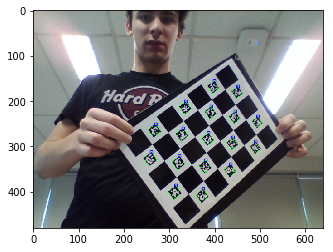

In [3]:
# Item 1
# Mostre aqui pelo menos uma imagem com o tabuleiro detectado

# Detecting markers in real time
aruco_dict = aruco.Dictionary_get(aruco.DICT_6X6_250)
parameters =  aruco.DetectorParameters_create()
charuco_board = cv2.aruco.CharucoBoard_create(5, 7, 0.032, 0.024, aruco_dict)

markers_corners = []
markers_ids = []
img_size = 0

for i in range(10):
    frame = cv2.imread("img"+str(i)+".jpeg")
    gray_image = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    img_size = gray_image.shape
    markers, ids, rejectedImgPoints = aruco.detectMarkers(gray_image, aruco_dict, parameters=parameters)
    if (len(markers) <= 0):
            print("Nenhum marcador encontrado.")
    else:
        _, corners, m_ids = cv2.aruco.interpolateCornersCharuco(markers, ids, gray_image, charuco_board)
        markers_corners.append(corners)
        markers_ids.append(m_ids)

img = frame.copy()
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img = cv2.aruco.drawDetectedMarkers(img, markers)
plt.imshow(img)

In [4]:
# Itens 2 e 3
# Imprima aqui os resultados da calibração

#Calibração
c = cv2.aruco.calibrateCameraCharuco(markers_corners, markers_ids, charuco_board, img_size, None, None, flags=cv2.CALIB_RATIONAL_MODEL)
print(c)

#Salvar calibração em Pickle
with open('calibratecharuco.p', 'wb') as fp:
    pickle.dump(c, fp, protocol=pickle.HIGHEST_PROTOCOL)

(0.4198653787062844, array([[589.89969658,   0.        , 323.40973898],
       [  0.        , 590.90294857, 261.50128996],
       [  0.        ,   0.        ,   1.        ]]), array([[-2.39106073e+00, -5.10231977e+00,  1.39853914e-02,
         6.07566211e-03, -1.40461104e+02, -2.53300104e+00,
        -3.47506549e+00, -1.45050337e+02,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00]]), [array([[ 2.10178833],
       [ 1.56287457],
       [-0.10040678]]), array([[ 1.70669669],
       [-2.0673285 ],
       [ 0.43662796]]), array([[ 1.79328538],
       [-2.23682633],
       [ 0.5594495 ]]), array([[ 2.66205567],
       [-0.13513134],
       [ 0.09168294]]), array([[ 2.68520068],
       [-0.17745067],
       [ 0.14686903]]), array([[2.26617035],
       [2.02799336],
       [0.00916097]]), array([[2.78484235],
       [1.0386783 ],
       [0.39093574]]), array([[ 1.85487037],
       [ 2.36006043],
       [-0.1074068 ]]), arra

In [8]:
# Item 4
# Estime a pose do tabuleiro e desenhe os eixos (XYZ)

calibration = pickle.load(open('calibratecharuco.p', 'rb'))

# Detecting markers in real time
aruco_dict = aruco.Dictionary_get(aruco.DICT_6X6_250)
parameters =  aruco.DetectorParameters_create()
charuco_board = cv2.aruco.CharucoBoard_create(5, 7, 0.032, 0.024, aruco_dict)
cap = cv2.VideoCapture(0)

while(True):
    ret, frame = cap.read() #640x480
    gray_image = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    img_size = gray_image.shape
    markers, ids, rejectedImgPoints = aruco.detectMarkers(gray_image, aruco_dict, parameters=parameters)
#     if (len(markers) <= 0):
#         continue
# #         print("Nenhum marcador encontrado.")
#     else:
    if (len(markers) > 0):
        found_markers = cv2.aruco.drawDetectedMarkers(frame, markers)
        _, corners, m_ids = cv2.aruco.interpolateCornersCharuco(markers, ids, gray_image, charuco_board)
        _, rvec, tvec = cv2.aruco.estimatePoseCharucoBoard(corners, m_ids, charuco_board, calibration[1], calibration[2])

        try:
            frame = aruco.drawAxis(frame, calibration[1], calibration[2], rvec, tvec, 0.1)
        except:
            pass
    
    # Show image, press esc to exit
    cv2.imshow('clean image', frame)

    k = cv2.waitKey(33)
    if k == 27: #esc
        break
    else:
        continue

# Clean everything up
cap.release()
cv2.destroyAllWindows()

## Referências

- Multiple View Geometry in Computer Vision. Hartley, R. e Zisserman, A. Capítulo 7.
- Computer Vision. Szeliski, R. Capítulo 6.
- https://docs.opencv.org/3.1.0/df/d4a/tutorial_charuco_detection.html
- https://docs.opencv.org/3.4.3/da/d13/tutorial_aruco_calibration.html
- http://answers.opencv.org/question/98447/camera-calibration-using-charuco-and-python/

Algumas imagens utilizadas foram extraídas de: https://docs.opencv.org/3.1.0/df/d4a/tutorial_charuco_detection.html